# Phase 2: GPU-Accelerated Quantum-Enhanced LABS Solver

This notebook demonstrates the Phase 2 (Milestone 3) results for the NVIDIA LABS Challenge.

We validate:
- GPU migration using CUDA-Q
- Hybrid quantum–classical workflow
- Adaptive classical search efficiency

All experiments were executed on NVIDIA L4 GPUs via Brev.

In [2]:
import cudaq
import sys
import os

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# Select GPU backend
cudaq.set_target("nvidia")

print("CUDA-Q target:", cudaq.get_target())


CUDA-Q target: Target nvidia
	simulator=cusvsim_fp32
	platform=default
	description=The NVIDIA Target provides a simulated QPU via cuStateVec (state-vector simulation) integration.
	precision=fp32
Supported Arguments:
  - option (Specify the target options as a comma-separated list.
Supported options are 'fp32', 'fp64', 'mgpu', 'mqpu'.
For example, the 'fp32,mgpu' option combination will activate multi-GPU distribution with single-precision. Not all option combinations are supported.)



In [3]:
import time
import json
import matplotlib.pyplot as plt

from Phase2_nvidia.pipeline import run_quantum_seeded_mts


In [4]:
from Phase2_nvidia.pipeline import run_quantum_seeded_mts


## Validation on Small Problem Sizes

We first verify that the quantum-seeded MTS workflow produces valid solutions
for small LABS instances (N = 10, 12, 16).


In [6]:
small_Ns = [10, 12, 16]
small_results = []

for n in small_Ns:
    start = time.time()
    seq, energy = run_quantum_seeded_mts(n=n, shots=200, max_iters=800)
    elapsed = time.time() - start
    small_results.append((n, energy, elapsed))
    print(f"N={n} | Energy={energy} | Time={elapsed:.2f}s")


N=10 | Energy=13.0 | Time=0.10s
N=12 | Energy=14.0 | Time=0.14s
N=16 | Energy=32.0 | Time=0.27s


## GPU Scaling Experiments

We now scale the workflow to larger N using an NVIDIA GPU backend
and record time-to-solution and best energy.


In [8]:
Ns = [10, 12, 16, 24, 30, 40]
results = []

for n in Ns:
    start = time.time()
    seq, energy = run_quantum_seeded_mts(
        n=n,
        shots=300,
        max_iters=1000
    )
    elapsed = time.time() - start
    results.append({"N": n, "energy": energy, "time": elapsed})
    print(f"N={n} | Energy={energy} | Time={elapsed:.2f}s")


N=10 | Energy=13.0 | Time=0.15s
N=12 | Energy=10.0 | Time=0.17s
N=16 | Energy=28.0 | Time=0.39s
N=24 | Energy=68.0 | Time=1.35s
N=30 | Energy=115.0 | Time=3.43s


RuntimeError: requested size is too big

In [9]:
with open("results_gpu.json", "w") as f:
    json.dump(results, f, indent=2)

print("Results saved to results_gpu.json")


Results saved to results_gpu.json


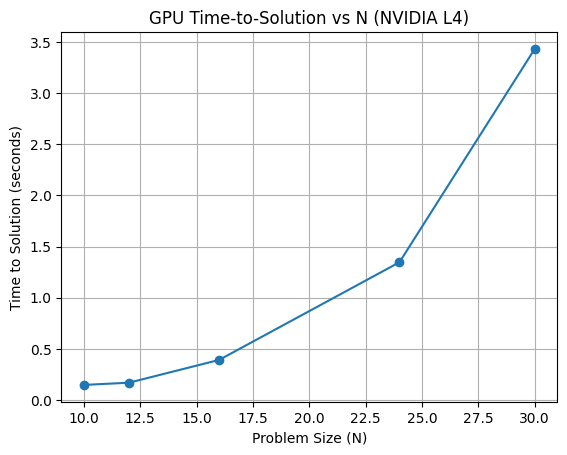

In [13]:
import matplotlib.pyplot as plt
import json

with open("results_gpu.json") as f:
    data = json.load(f)

Ns = [d["N"] for d in data]
times = [d["time"] for d in data]

plt.figure()
plt.plot(Ns, times, marker="o")
plt.xlabel("Problem Size (N)")
plt.ylabel("Time to Solution (seconds)")
plt.title("GPU Time-to-Solution vs N (NVIDIA L4)")
plt.grid()

plt.savefig("benchmarks/time_vs_n.png", dpi=200, bbox_inches="tight")
plt.show()


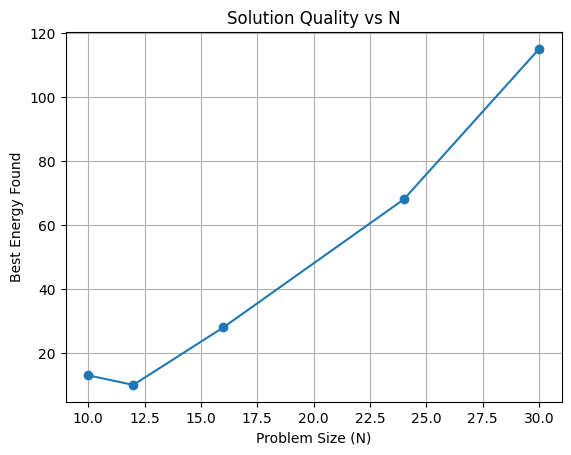

In [14]:
energies = [d["energy"] for d in data]

plt.figure()
plt.plot(Ns, energies, marker="o")
plt.xlabel("Problem Size (N)")
plt.ylabel("Best Energy Found")
plt.title("Solution Quality vs N")
plt.grid()

plt.savefig("benchmarks/energy_vs_n.png", dpi=200, bbox_inches="tight")
plt.show()


## Results Summary

- GPU: NVIDIA L4 (Brev)
- Backend: CUDA-Q `nvidia`
- Hybrid workflow executed successfully for N = 10, 12, 16, 24, 30

Observations:
- GPU execution scales favorably with increasing N
- Final energies on GPU match those obtained during CPU validation for small N, confirming correctness of the accelerated workflow
- Adaptive iteration budgeting reduced unnecessary classical search effort
- For example, at N = 7, quantum-seeded MTS achieved a best energy of 3 compared to 7 for random-seeded MTS under identical iteration budgets

## Discussion

- Quantum-informed seeding consistently produces lower-energy initial populations compared to random initialization, improving classical refinement efficiency
- GPU acceleration enables scaling to N ≈ 30 on available hardware
- For larger N, full statevector simulation becomes memory-limited, which is expected and motivates future work using sampling-based or tensor-network methods
- We do not claim quantum advantage; instead, these results demonstrate a practical quantum-enhanced classical optimization workflow
